In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import text_processing

## Training and validation loss charts

In [2]:
def get_losses(csv_path):
    """
    Returns losses from a callback csv file
    
    :param: csv_path - path to csv file with losses
    """
    callback_df = pd.read_csv(csv_path)
    return callback_df['loss'], callback_df['val_loss']

In [3]:
gru_path = './callbacks/VGG16_GRU_flickr8k_2l_32b.csv'
gru_bn_dr_path = './callbacks/VGG16_GRU_flickr8k_2l_32b_bn_dr.csv'
lstm_path = './callbacks/VGG16_LSTM_flickr8k_2l_32b_bn_dr.csv'
bahdanau_path = './callbacks/VGG16_LSTM_flickr8k_2l_32b_bn_dr_attn_bahdanau.csv'
scaled_dot_path = './callbacks/VGG16_LSTM_flickr8k_2l_32b_bn_dr_attn_scaled_dot.csv'

In [4]:
gru_train_loss, gru_val_loss = get_losses(gru_path)
gru_bn_dr_train_loss, gru_bn_dr_val_loss = get_losses(gru_bn_dr_path)
lstm_train_loss, lstm_val_loss = get_losses(lstm_path)
bahdanau_train_loss, bahdanau_val_loss = get_losses(bahdanau_path)
scaled_dot_train_loss, scaled_dot_val_loss = get_losses(scaled_dot_path)

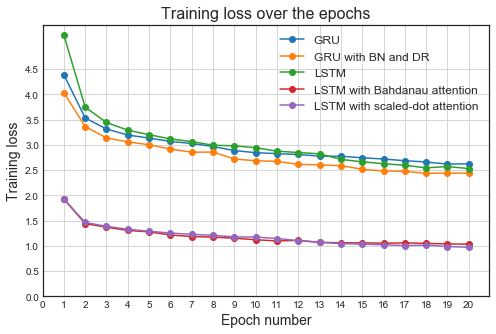

In [5]:
sns.set_style('white')
x_range = np.arange(1, 21)

plt.figure(figsize=(8,5))

plt.plot(x_range, gru_train_loss, label='GRU', marker='o')
plt.plot(x_range, gru_bn_dr_train_loss, label='GRU with BN and DR', marker='o')
plt.plot(x_range, lstm_train_loss, label='LSTM', marker='o')
plt.plot(x_range, bahdanau_train_loss, label='LSTM with Bahdanau attention', marker='o')
plt.plot(x_range, scaled_dot_train_loss, label='LSTM with scaled-dot attention', marker='o')

plt.xticks(np.arange(0, 21))
plt.yticks(np.arange(0, 5, 0.5))

plt.xlabel('Epoch number', fontsize=14)
plt.ylabel('Training loss', fontsize=14)
plt.title('Training loss over the epochs', fontsize=16)
plt.grid()
plt.legend(fontsize=12)
plt.show()

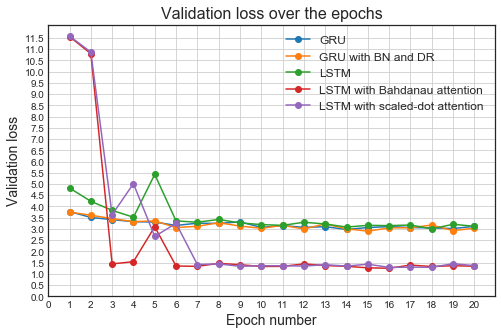

In [6]:
sns.set_style('white')
x_range = np.arange(1, 21)

plt.figure(figsize=(8,5))

plt.plot(x_range, gru_val_loss, label='GRU', marker='o')
plt.plot(x_range, gru_bn_dr_val_loss, label='GRU with BN and DR', marker='o')
plt.plot(x_range, lstm_val_loss, label='LSTM', marker='o')
plt.plot(x_range, bahdanau_val_loss, label='LSTM with Bahdanau attention', marker='o')
plt.plot(x_range, scaled_dot_val_loss, label='LSTM with scaled-dot attention', marker='o')

plt.xticks(np.arange(0, 21))
plt.yticks(np.arange(0, 12, 0.5))

plt.xlabel('Epoch number', fontsize=14)
plt.ylabel('Validation loss', fontsize=14)
plt.title('Validation loss over the epochs', fontsize=16)
plt.grid()
plt.legend(fontsize=12)
plt.show()

## Analysis of diversity of the generated captions

In [7]:
gru_path = './captions/VGG16_GRU_flickr8k_2l_32b.txt'
gru_bn_dr_path = './captions/VGG16_GRU_flickr8k_2l_32b_bn_dr.txt'
lstm_path = './captions/VGG16_LSTM_flickr8k_2l_32b_bn_dr.txt'
bahdanau_path = './captions/VGG16_LSTM_flickr8k_2l_32b_bn_dr_attn_bahdanau_3b.txt'
scaled_dot_path = './captions/VGG16_LSTM_flickr8k_2l_32b_bn_dr_attn_scaled_dot.txt'

In [8]:
def read_captions(path):
    """
    Reads captions from a file corresponding do a given file
    """
    with open(path, 'r') as captions_file:
        captions = [caption[:-1] for caption in captions_file.readlines()]
    return captions

def get_captions_vocab(captions):
    vocab = text_processing.Vocabulary()
    for caption in captions:
        for word in caption.split():
            vocab.add_word(word)
    return vocab

In [9]:
gru_captions = read_captions(gru_path)
gru_vocab = get_captions_vocab(gru_captions)
gru_vocab.number_of_words

117

In [10]:
gru_bn_dr_captions = read_captions(gru_bn_dr_path)
gru_bn_dr_vocab = get_captions_vocab(gru_bn_dr_captions)
gru_bn_dr_vocab.number_of_words

251

In [11]:
lstm_captions = read_captions(lstm_path)
lstm_vocab = get_captions_vocab(lstm_captions)
lstm_vocab.number_of_words

254

In [12]:
bahdanau_captions = read_captions(bahdanau_path)
bahdanau_vocab = get_captions_vocab(bahdanau_captions)
bahdanau_vocab.number_of_words

249

In [13]:
scaled_dot_captions = read_captions(scaled_dot_path)
scaled_dot_vocab = get_captions_vocab(scaled_dot_captions)
scaled_dot_vocab.number_of_words

269